# Submission 3: Modeling and Strategy Development

Group members: 

1. Tai Chun Long
2. Chi Khanh Ta
3. Marcin Majchrzak
      
Date: 19 Nov 2018

# Table of contents<a id = 'Table'></a>

1. [Instructions](#Instructions)
2. [Question 1](#Question1)
    1. [Import Modules](#modules)
    2. [Download Prices](#yahoo)
    3. [Features/Explanatory Variables](#features)
3. [Question 2](#Question2)
    1. [Artificial Neural Network (ANN)](#ANN)
    2. [Long Short Term Memory (LSTM)](#LSTM)
    3. [Support Vector Machine (SVM)](#SVM)
    4. [Gaussian Naive Bayes (GNB)](#GNB)
4. [Question 3](#Question3)
    1. [Cross Validation Technique](#cross)
5. [Question 4](#Question4)
    1. [Confusion Matrix, Precision, Recall, F1-Score, Accuracy and AUC](#cm)
    2. [ROC Curves](#roc)
    3. [PCA Feature Selection](#pca)
6. [Question 5](#Question5)
7. [Fund Factsheet](#FundFactsheet)
    1. [Maximum Drawdown](#MaxDrawdown)
    2. [Annualized Return](#annual_ret)
    3. [Sharpe Ratio](#sharpe)
    4. [Equity Curve](#EquityCurve)

# Instructions<a id = 'Instructions'></a>
[Top](#Table)

Using what you have learnt from Submissions 1 and 2, implement a trading strategy using machine learning. We recommend that students focus on classification – for example: trying to forecast if a stock will move up and down, above some threshold such as the 90-day standard deviation.

1. Decide on an algorithm or group of algorithms (for example, ensemble techniques).
2. Fit the model.
3. Show that it works out of sample, and use appropriate cross-validation techniques.
4. Provide the following performance metrics:
(a) ROC curves,
(b) Confusion Matrix,
(c) Precision, Recall, F1-Score, Accuracy, and AUC.
5. Analysis of metrics and report.

Fund factsheet

Create a fund factsheet for your new investment strategy. Have a look at examples of popular
funds found online and create a fact sheet with all the bells and whistles. It must at a minimum
include (Pyfolio can be used):

1. Maximum Drawdown
2. Annualized Returns
3. Sharpe Ratio
4. Plot the Equity Curve

##  Question 1<a id = 'Question1'></a>
[Top](#Table)

We have selected four machine learning models in the process to pick the best or the most suitable algorithm for our research. The models are feed-forward Artificial Neural Network (ANN), Long Short Term Memory (LSTM), Support Vector Machine (SVM) and Naive Bayes. The features or explanatory variables are then fitted into each of the models and performance metrics for all of them are calculated. We will then pick the model with the highest F1 score and use the signals predicted from the model to run our backtesting trades.

### A. Import modules into the program:<a id = 'modules'></a>
[Top](#Table)

In [3]:
# !pip install pillow
!pip install pyfolio

    100% |████████████████████████████████| 92kB 693kB/s 
    100% |████████████████████████████████| 51kB 7.2MB/s 
  Running setup.py bdist_wheel for pyfolio ... done
  Stored in directory: /Users/chita/Library/Caches/pip/wheels/37/9b/a6/199481975c168cc22c6161fbf8a6f0e6037d6e2faf2d0fba53
  Running setup.py bdist_wheel for empyrical ... done
  Stored in directory: /Users/chita/Library/Caches/pip/wheels/83/14/73/34fb27552601518d28bd0813d75124be76d94ab29152c69112
Successfully built pyfolio empyrical


In [1]:
%load_ext watermark
%watermark

import fix_yahoo_finance as yf
import pandas as pd
import numpy as np
import backtrader as bt
import pyfolio as pf
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, f1_score, precision_score, recall_score, confusion_matrix, auc, accuracy_score,classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as gnb # Naive Bayes
from sklearn.decomposition import PCA

2018-11-20T05:49:49+08:00

CPython 3.5.6
IPython 6.5.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
CPU cores  : 4
interpreter: 64bit


Using TensorFlow backend.


### B. Download asset prices from Yahoo Finance:<a id = 'yahoo'></a>
[Top](#Table)

In this case, we pick McDonald's as the equity for our model/research:

In [2]:
yf.pdr_override()
# Download McD stock price
McD = pdr.get_data_yahoo("MCD", start = "1998-11-10", end = "2018-11-10")
McD.tail()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-11-05,177.410004,181.100006,177.000000,180.389999,180.389999,4747300
2018-11-06,180.029999,182.860001,179.490005,182.710007,182.710007,4864700
2018-11-07,183.000000,184.479996,181.880005,184.250000,184.250000,4363900
2018-11-08,184.289993,186.039993,184.080002,185.479996,185.479996,3318600
2018-11-09,186.000000,186.580002,185.070007,185.940002,185.940002,3237000


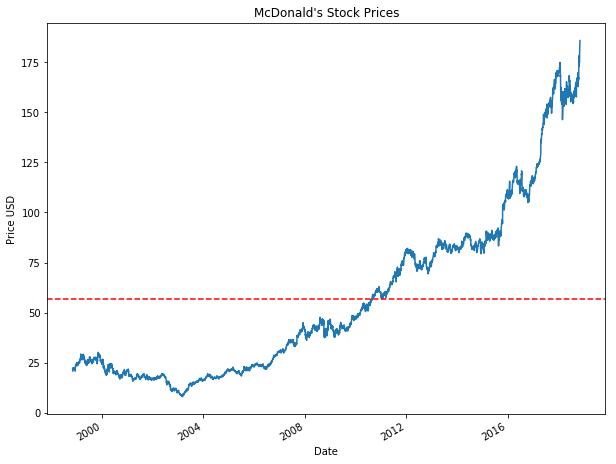

In [3]:
# Daily stock price trend
f, ax = plt.subplots(figsize = (10, 8))
McD['Adj Close'].plot(ax = ax)
ax.axhline(McD['Adj Close'].mean(), ls = '--', color = 'red')
plt.title("McDonald's Stock Prices")
plt.ylabel("Price USD")
plt.show()

### C. Constructing features/explanatory variables as the inputs for machine learning models:<a id = 'features'></a>
[Top](#Table)

In [4]:
def ma(x, n, type = 'simple'):
    """
    compute an n period moving average.
    type is 'simple' | 'exponential'
    """
    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    
    return a

In [5]:
def ma_cd(x, nslow = 26, nfast = 12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    
    emaslow = ma(x, nslow, type = 'exponential')
    emafast = ma(x, nfast, type = 'exponential')
    
    return emaslow, emafast, emafast - emaslow

In [6]:
window_length = 20
delta = McD['Adj Close'].diff()
# Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
delta = delta[1:] 

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

# Calculate the SMA
roll_up = pd.Series(up).rolling(window = window_length).mean()
roll_down = pd.Series(down.abs()).rolling(window = window_length).mean()

# Calculate the RSI based on SMA
RS = roll_up / roll_down
RSI = 100.0 - (100.0 / (1.0 + RS))

In [7]:
# compute the MACD indicator
nfast = 12
nslow = 26
emaslow, emafast, macd = ma_cd(McD["Adj Close"], nslow = nslow, nfast = nfast)

# using exponential moving average
McD_ema = pd.Series.ewm(McD['Adj Close'], span = 100).mean()

McD['SMA'] = ma(McD['Adj Close'], 50, type = 'simple')
McD['MACD'] = macd
McD['EMA'] = McD_ema
McD['RSI'] = RSI
McD['MOM'] = McD['Adj Close'].diff(1).dropna()  
McD['ROC'] = McD['Adj Close'].pct_change(1).dropna()
McD['dif_10'] = McD['Adj Close'].diff(10).dropna()
McD['dif_30'] = McD['Adj Close'].diff(30).dropna()

##  Question 2<a id = 'Question2'></a> 
[Top](#Table)

The above features/explanatory variables are fitted into a feed-forward Artificial Neural Network (ANN), Long Short Term Memory (LSTM), Support Vector Classification (SVC) and Gaussian Naive Bayes (GaussianNB) for models training and comparison.

In [8]:
# define the output value as price rise, which is a binary variable storing 1 when the closing price of tomorrow is greater 
# than the closing price of today.
McD['time_t'] = np.where(McD['Adj Close'].shift(-1) > McD['Adj Close'], 1, 0)

# Add more time series features 
McD['time_t+1'] = McD.time_t.shift(1)
McD['time_t+2'] = McD.time_t.shift(2)
McD = McD.dropna()

X = McD.iloc[:,6:16]  # achieve higher accuracy, lower loss
y = McD.iloc[:,16]   

split = int(len(McD) * 0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# normalize the data 
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train)
# y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1,1))
X_test= x_scaler.transform(X_test)
# X_test= y_scaler.transform(np.array(y_test).reshape(-1,1))

McD.tail()

C:\Users\long\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\long\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\long\Anaconda3\envs\wqu_ml_fin\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.


,Open,High,Low,Close,Adj Close,Volume,SMA,MACD,EMA,RSI,MOM,ROC,dif_10,dif_30,time_t,time_t+1,time_t+2
Date,,,,,,,,,,,,,,,,,
2018-11-05,177.410004,181.100006,177.000000,180.389999,180.389999,4747300,166.557193,5.126113,164.645971,64.399800,3.639999,0.020594,13.759994,17.080001,1,1.0,1.0
2018-11-06,180.029999,182.860001,179.490005,182.710007,182.710007,4864700,167.021705,6.027741,165.003674,64.609791,2.320008,0.012861,5.560013,16.300003,1,1.0,1.0
2018-11-07,183.000000,184.479996,181.880005,184.250000,184.250000,4363900,167.493961,7.108373,165.384790,67.980066,1.539993,0.008429,6.899994,18.490005,1,1.0,1.0
2018-11-08,184.289993,186.039993,184.080002,185.479996,185.479996,3318600,167.961600,6.815390,165.782714,78.144507,1.229996,0.006676,10.169998,18.949997,1,1.0,1.0
2018-11-09,186.000000,186.580002,185.070007,185.940002,185.940002,3237000,168.444600,6.586486,166.181869,77.929263,0.460006,0.002480,12.600006,18.650009,0,1.0,1.0


C:\Users\long\Anaconda3\envs\wqu_ml_fin\lib\site-packages\matplotlib\figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


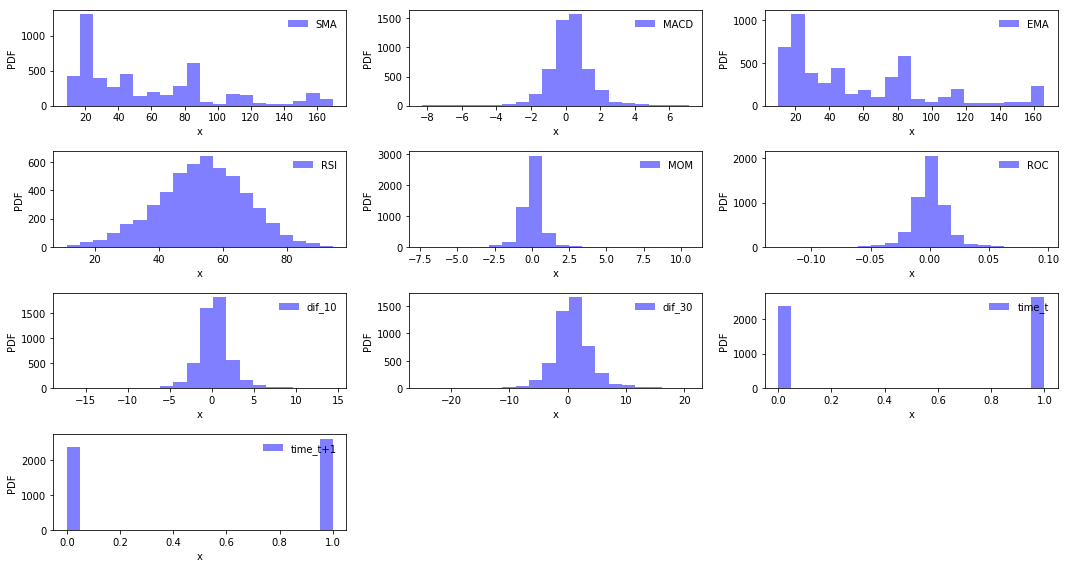

In [12]:
# Define subplots
fig, axes = plt.subplots(4, 3, figsize = (15, 8), tight_layout = True)

# Plot features distribution
counter = 0
for i in range (4):
    for j in range(3):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(X.columns):

            ax.hist(X[X.columns[counter]], bins = 20, color = 'blue', alpha = 0.5, label = '{}'.format(X.columns[counter]))
            ax.set_xlabel('x')
            ax.set_ylabel('PDF')
            leg = ax.legend(loc = 'upper right')
            leg.draw_frame(False)

        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

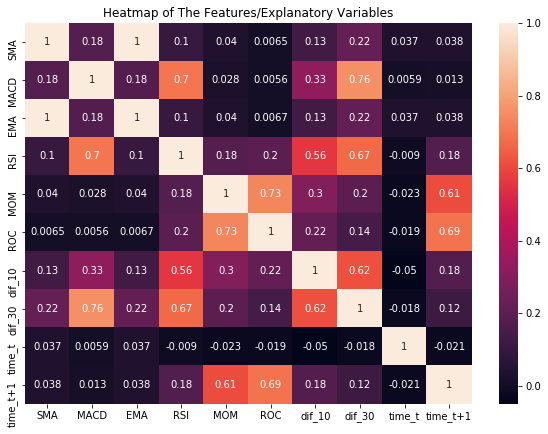

In [14]:
corr = McD.iloc[:,6:16].corr()

# plot the heatmap
fig, ax = plt.subplots(figsize = (10, 7))         # Sample figsize in inches
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, ax = ax, annot = True)
ax.set_title('Heatmap of The Features/Explanatory Variables')
plt.show()

### A. Constructing a feed-forward Artificial Neural Network (ANN) Model<a id = 'ANN'></a>:
[Top](#Table)

In [11]:
def ANN_feed_forward():
    model = Sequential()
    model.add(Dense(units = 1000, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
    model.add(Dense(units = 500, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units = 250, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units = 125, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units = 75, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

    return model

ann = ANN_feed_forward()
ann.fit(X_train, y_train, batch_size = 10, epochs = 50)  

Epoch 1/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2385 - acc: 0.5877
Epoch 2/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2315 - acc: 0.6239
Epoch 3/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2307 - acc: 0.6174A: 0s - loss: 0.2300 - acc
Epoch 4/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2282 - acc: 0.6274A: 1s 
Epoch 5/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2283 - acc: 0.6259A: 0s - loss: 0.2281 - 
Epoch 6/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2269 - acc: 0.6241
Epoch 7/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2270 - acc: 0.6309A
Epoch 8/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2263 - acc: 0.6264
Epoch 9/50
4004/4004 [==============================] - 8s 2ms/step - loss: 0.2247 - acc: 0.6329
Epoch 10/50
4004/4004 [==============================] - 8s 2ms/step - 

In [12]:
# score
score = ann.evaluate(X_test, y_test, batch_size = 10)

print('\nTest loss:', score[0])
print('Test accuracy:', score[1]) 

1001/1001 [==============================] - 0s 348us/step

Test loss: 0.33572433330304735
Test accuracy: 0.6003996068006986


From several testing, we got a few results after 50 epochs:

1. X: (without time series features (t and t+1), achieved loss: 0.24, acc: 0.58
2. X: all features from 0 to 16, achieved loss: 0.18, acc: 0.715
3. X: features from 6 to 16, achieved loss: 0.15, acc: 0.78

Therefore, we choose features from X = McD[:,6:16] and y = McD[:,16] as the fixed sets for our model.

### B. Constructing a Long Short Term Memory (LSTM) Model<a id = 'LSTM'></a>:
[Top](#Table)

Long short term memory LSTM), a kind of Recurrent Neural Networks (RNN) has been researched and regarded as a better model than ANN for time series prediction as it cares about the time order and can decide which information should be forgotten and which inputs are used as features.

References:

1. Klaus Greff, Rupesh K. Srivastava, Jan Koutn ́ık, Bas R. Steunebrink, Ju ̈rgen Schmidhuber, *"LSTM: A Search Space Odyssey"* (2016)

2. Sreelekshmy Selvin, Vinayakumar R, Gopalakrishnan E.A, Vijay Krishna Menon, Soman K.P (2017) *"STOCK PRICE PREDICTION USING LSTM, RNN AND CNN-SLIDING WINDOW MODEL"* 

3. Jason Brownlee (2016) *Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras.* Available at https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/ (Accessed: 18 Nov 2018)

In [13]:
# reshape input to be [samples, time steps, features]
lstm_X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
lstm_X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
def lstm_model():
    hidden_size = 32
    model = Sequential()
    model.add(LSTM(hidden_size,input_shape = (X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', metrics = ['accuracy'], optimizer = 'adam')
    
    return model

# score
lstm = lstm_model()
lstm.fit(lstm_X_train, y_train, epochs = 50, batch_size = 32) 

score = lstm.evaluate(lstm_X_test, y_test, batch_size = 32)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1]) 

Epoch 1/50
4004/4004 [==============================] - 2s 624us/step - loss: 0.2976 - acc: 0.4960
Epoch 2/50
4004/4004 [==============================] - 1s 293us/step - loss: 0.2531 - acc: 0.5310
Epoch 3/50
4004/4004 [==============================] - 1s 292us/step - loss: 0.2499 - acc: 0.5455
Epoch 4/50
4004/4004 [==============================] - 1s 298us/step - loss: 0.2488 - acc: 0.5402
Epoch 5/50
4004/4004 [==============================] - 1s 291us/step - loss: 0.2481 - acc: 0.5524
Epoch 6/50
4004/4004 [==============================] - 1s 293us/step - loss: 0.2480 - acc: 0.5495
Epoch 7/50
4004/4004 [==============================] - 1s 298us/step - loss: 0.2480 - acc: 0.5492
Epoch 8/50
4004/4004 [==============================] - 1s 295us/step - loss: 0.2489 - acc: 0.5395
Epoch 9/50
4004/4004 [==============================] - 1s 294us/step - loss: 0.2471 - acc: 0.5612
Epoch 10/50
4004/4004 [==============================] - 1s 294us/step - loss: 0.2462 - acc: 0.5587
Epoch 11/

From several testing, we got a few results after 50 epochs:

1. X: (without time series features (t and t+1), achieved loss: 0.24, acc: 0.58
2. X: all features from 0 to 16, achieved loss: 0.24, acc: 0.57
3. X: features from 6 to 16, achieved loss: 0.24, acc: 0.57

Therefore , we choose features from X = McD[:,6:16] and y = McD[:,16] as the fixed sets for our model.

### C. Constructing a Support Vector Machine (SVM) Model:<a id = 'SVM'></a>
[Top](#Table)

In [15]:
#. Support vector Machine Model
svc = SVC(kernel = 'rbf')  # Radial Basis Function Kernel, sigmoid: which is suitable for binary classification
svc.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### D. Constructing a Gaussian Naive Bayes (GNB) Model:<a id = 'GNB'></a>
[Top](#Table)

In [16]:
# Gaussian Naive Bayes (GNB)
gaussian = gnb() # Gaussian Kernel, sigmoid: which is suitable for binary classification
gaussian.fit(X_train, y_train) 

GaussianNB(priors=None, var_smoothing=1e-09)

## Question 3<a id = 'Question3'></a>
[Top](#Table)

We use TimeSeries Split as the cross validation technique in our model/research. TimeSeriesSplit is the popular cross validation method for time series. As we need to keep the sequence of time series, we cannot split randomly. Instead, the argorithm works like the steps below:

1. Folds for time series cross valdiation are created in a forward chaining fashion
2. Suppose we have a time series for yearly consumer demand for a product during a period of n years.

Reference:

SUNIL RAY (2018) *Improve Your Model Performance using Cross Validation (in Python and R)* Available at https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r. (Accessed: 18 Nov 2018)

### A. Cross Validation Technique:<a id = 'cross'></a>
[Top](#Table)

NB: mean: 0.576374 std: 0.013049


C:\Users\long\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\long\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\long\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\long\Anaconda3\envs\wqu_m

SVM: mean: 0.609615 std: 0.014919
ANN: mean: 0.560165 std: 0.032143
LSTM: mean: 0.557418 std: 0.022569


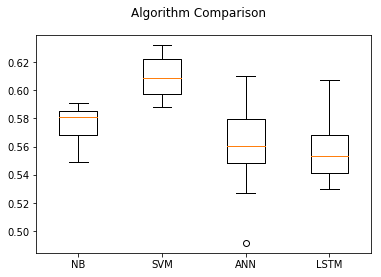

In [51]:
# this part of the code will take longer time to generate output

# %%time
# Spot Check Algorithms

# Wrap Keras model so it can be used by scikit-learn
ANN_model = KerasClassifier(build_fn = ANN_feed_forward, epochs = 50, batch_size = 10, verbose = 0)
LSTM_model = KerasClassifier(build_fn = lstm_model, epochs = 50, batch_size = 10, verbose = 0)

models = []
models.append(('NB', gnb()))
models.append(('SVM', SVC()))
models.append(('ANN', ANN_model))
models.append(('LSTM', LSTM_model))

# evaluate each model in turn
results = []
names = []

# %%time
for name, model in models:
    if name != 'LSTM':
        x_train = X_train
    else:
        x_train = lstm_X_train
        
    # Use timeseriessplit as the cross validation method.
    tscv = TimeSeriesSplit(n_splits = 10)
    # different scoring 'precision','recall','f1','roc_auc' for binary targets only
    cv_results = cross_val_score(model, x_train, y_train, cv = tscv, scoring = 'accuracy') 
    results.append(cv_results)
    names.append(name)
    msg = "%s: mean: %f std: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [17]:
# Predict Y for each models (out of samples)
pre_lst = []

ann_y_pred = ann.predict(X_test) 
lstm_y_pred = lstm.predict(lstm_X_test)
svc_y_pred = svc.predict(X_test)
gs_y_pred = gaussian.predict(X_test)

# Get y_prediction list for each model
pre_lst.append(('ANN', ann_y_pred))
pre_lst.append(('LSTM', lstm_y_pred))
pre_lst.append(('SVM', svc_y_pred))
pre_lst.append(('Naive Bayes', gs_y_pred))

C:\Users\long\Anaconda3\envs\wqu_ml_fin\lib\site-packages\matplotlib\figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


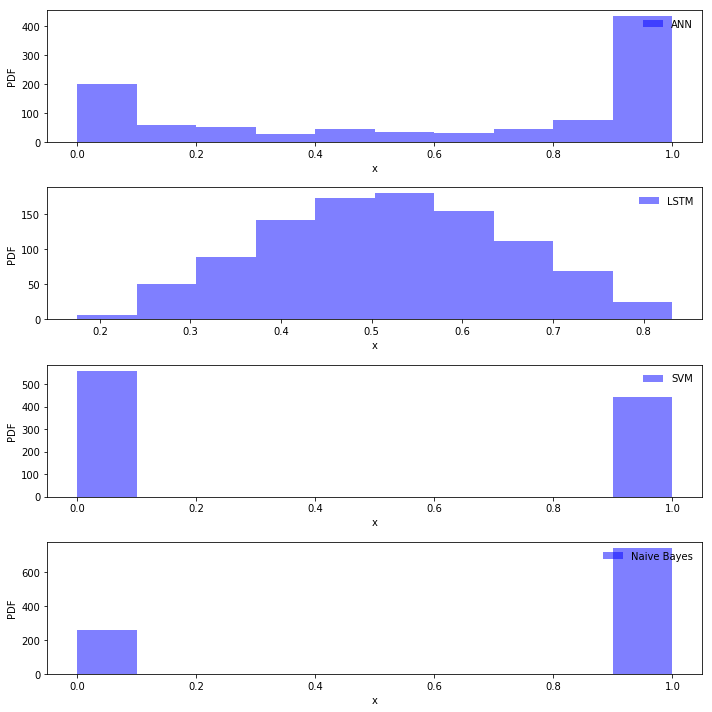

In [18]:
# Define subplots
fig, axes = plt.subplots(4, 1, figsize = (10, 10), tight_layout = True)

# Plot features distribution
count = 0
for name, i in pre_lst:
        ax = axes[count]
        # Plot when we have data
        ax.hist(i, bins = 10, color = 'blue', alpha = 0.5, label = '{}'.format(name))
        ax.set_xlabel('x')
        ax.set_ylabel('PDF')
        leg = ax.legend(loc = 'upper right')
        leg.draw_frame(False)
        count += 1
        
plt.show()

##  Question 4<a id = 'Question4'></a>
[Top](#Table)

The followig codes show the calculations of performance metrics for all models under research.

###  A. Confusion Matrix, Precision, Recall, F1-Score, Accuracy and AUC<a id = 'cm'></a>
[Top](#Table)

In [19]:
# Set threshold to categorize the y_predict
def performance_metric(threshold, y_predict):
    y_pre = [1 if x > threshold else 0 for x in y_predict]

    # 1.calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pre)
    print("Thresholds: {}".format(thresholds),
         "fpr: {}".format(fpr),
         "tpr: {}".format(tpr))

    # 2.calculate confusion matrix
    con_mx = confusion_matrix(y_test, y_pre)
    print("Confusion Matrix:\n{}".format(con_mx))

    # 3.calculate f1
    f1_sco = f1_score(y_test, y_pre, labels = None, pos_label = 1)
    print("F1 Score: {}".format(f1_sco))

    # 4.calculate accuracy
    acc_score = accuracy_score(y_test, y_pre, normalize = True) 
    print("Accuracy Score: {}".format(acc_score))

    # 5.calculate precision_score
    pre_score = precision_score(y_test, y_pre, average = 'weighted')
    print("Precision Score: {}".format(pre_score))

    # 6.calculate recall score
    rec_score = recall_score(y_test, y_pre)
    print("Recall Score: {}".format(rec_score))

    # 7.calculate auc score
    auc_score = auc(fpr, tpr)
    print("AUC Score: {}".format(auc_score))

    return fpr, tpr, auc_score

In [20]:
# f1 score
name_lst = []
fpr_lst = []
tpr_lst = []
auc_score_lst = []

for name, y in pre_lst:
    print('Model: %s' %name )
    fpr, tpr, auc_score = performance_metric(0.5, y) # set threshold = 0.5
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    auc_score_lst.append(auc_score)
    name_lst.append(name)
    print()

Model: ANN
Thresholds: [2 1 0] fpr: [0.         0.51769912 1.        ] tpr: [0.         0.69763206 1.        ]
Confusion Matrix:
[[218 234]
 [166 383]]
F1 Score: 0.6569468267581474
Accuracy Score: 0.6003996003996004
Precision Score: 0.5967966730730101
Recall Score: 0.697632058287796
AUC Score: 0.5899664716217741

Model: LSTM
Thresholds: [2 1 0] fpr: [0.         0.48451327 1.        ] tpr: [0.         0.59198543 1.        ]
Confusion Matrix:
[[233 219]
 [224 325]]
F1 Score: 0.5946935041171089
Accuracy Score: 0.5574425574425574
Precision Score: 0.5578800181990747
Recall Score: 0.5919854280510018
AUC Score: 0.5537360768573594

Model: SVM
Thresholds: [2 1 0] fpr: [0.         0.35840708 1.        ] tpr: [0.         0.51001821 1.        ]
Confusion Matrix:
[[290 162]
 [269 280]]
F1 Score: 0.5650857719475277
Accuracy Score: 0.5694305694305695
Precision Score: 0.5816912751564967
Recall Score: 0.5100182149362478
AUC Score: 0.575805567645115

Model: Naive Bayes
Thresholds: [2 1 0] fpr: [0.      

### B. ROC curves<a id = 'roc'></a>
[Top](#Table)

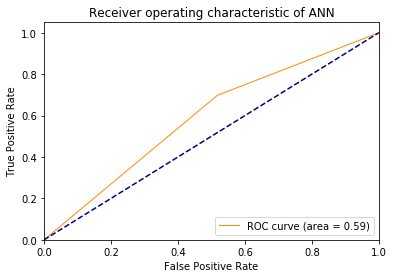

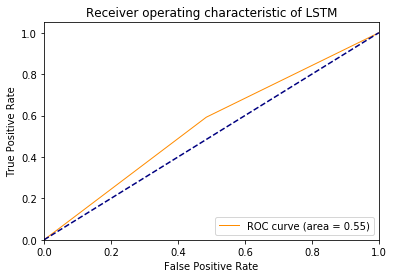

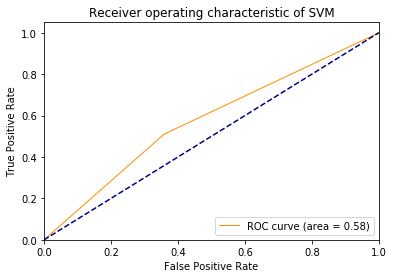

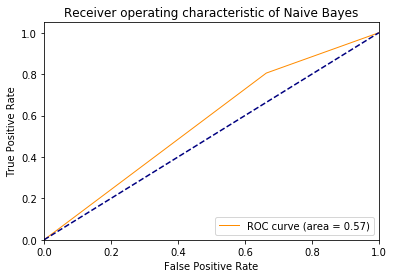

In [21]:
# Plot ROC_curve
def plot_roc_curve(fpr, tpr, auc_score):
    for fpr, tpr, auc_score, name in zip(fpr_lst, tpr_lst, auc_score_lst, name_lst):
        plt.figure()
        plt.plot(fpr, tpr, color = 'darkorange', lw = 1, label = 'ROC curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic of %s' %name)
        plt.legend(loc = "lower right")
        plt.show() 
        # plt.savefig('roc_curve.png') # Install Pillow in order to use savefig function
        
plot_roc_curve(fpr, tpr, auc_score)

Based on the performance metrics above, Naive Bayes gives the highest F1_score of 0.685 and the recall score is also high which is 0.805 on the test_set. Naive Bayes gives the best performance. The second best model is the feed-forward ANN model with a F1_score of 0.657. So predictions from Naive Bayes model will be used as signals for backtesting. 

### C. PCA Feature Selection<a id = 'pca'></a>
[Top](#Table)

PCA feature selection is carried out for Naive Bayes in order to see whether we can improve the model performance.

[0.32753046 0.22306156 0.19715589]
[114.51777028  94.50600411  88.84887003]


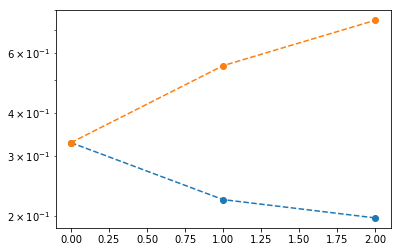

In [22]:
pca = PCA(n_components = 3)
pca_train = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_)  

# Plot PCA
plt.semilogy(pca.explained_variance_ratio_, '--o');
plt.semilogy(pca.explained_variance_ratio_.cumsum(), '--o');

In [23]:
# Fit new selected features to chosen model
principal_MCD = pd.DataFrame(data = pca_train)
gaussian.fit(principal_MCD, y_train)

pca_test = pca.fit_transform(X_test)
NB_y_pre = gaussian.predict(pca_test)

print(classification_report(y_test, NB_y_pre, target_names = ['down', 'up']))

              precision    recall  f1-score   support

        down       0.51      0.53      0.52       452
          up       0.60      0.57      0.58       549

   micro avg       0.55      0.55      0.55      1001
   macro avg       0.55      0.55      0.55      1001
weighted avg       0.56      0.55      0.55      1001



Since the accuracy is lower with reduced features, we should ignore PCA feature selection in this case

##  Question 5<a id = 'Question5'></a>
[Top](#Table)

**Report and Analysis**

The first step of our analysis involved the asset selection. Pandas datareader was used to download the last 20, 25, and 30 years of data. After, plotting the closing prices and calculating the volatilities, we selected 20 years MCD stock from yahoo finance. 

The second step required whitening the data using multiple explanatory variables, so our algorithms will not receive the false signals. Our choice of features/explanatory variables included:

* SMA (Simple Moving Average)
* EMA (Exponential Moving Average)
* MACD (Moving Average Convergence Divergence
* RSI (Relative Strength Index)
* MOM
* ROC
* 10 Days Moving Average
* 30 Days Moving Average

After optimizing the data, we run 4 different algorithms to see the which of them would give us the best accuracy and could be used for the prediction and back testing. Four different algorithms were chosen:

* ANN (Feed Forward Artificial Neural Network)
* LSTM (Long Short Term Memory)
* SVM (Support Vector Machine)
* GNB (Gaussian Naive Bayes)

The algorithms were run using different number of epochs. By trial and error it was concluded that 50 is the most suitable number of epochs giving the most accurate prediction. 

Later, the different metrics were used to select the model that would be eventually used in our back testing (Confusion Matrix, F1 Score, Accuracy Score, Precision Score, Recall Score, AUC score, ROC curve). 

Given the best metrics of F1 score, which is the weighted average of precision and recall, of 0.685, the GNB algorithm was chosen as a signal for our back testing. GNB had also second highest accuracy score of 0.59 comparing to best ANN with accuracy of 0.60. However, we chose F1 as the indicator of the algorithm preformance.

##  Fund Factsheet<a id = 'FundFactsheet'></a>
[Top](#Table)

In [24]:
# go long when gs_y_pred > 0.5, go short when gs_y_pred < 0.5
McD['gs_y_pred'] = np.NaN
McD.iloc[(len(McD) - len(gs_y_pred)):, -1:] = gs_y_pred

"""
from backtrader PandasDirectData:
        ('datetime', 0),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 5),
        ('openinterest', 6),
"""

df = pd.DataFrame(index = McD.index) 
df['Open'] = McD['Open'].values      
df['High'] = McD['High'].values      
df['Low'] = McD['Low'].values
df['Close'] = McD['Close'].values
df['Volume'] = McD['Volume'].values
df['openinterest'] = McD['gs_y_pred'].values
df.tail()

,Open,High,Low,Close,Volume,openinterest
Date,,,,,,
2018-11-05,177.410004,181.100006,177.000000,180.389999,4747300,0.0
2018-11-06,180.029999,182.860001,179.490005,182.710007,4864700,1.0
2018-11-07,183.000000,184.479996,181.880005,184.250000,4363900,1.0
2018-11-08,184.289993,186.039993,184.080002,185.479996,3318600,1.0
2018-11-09,186.000000,186.580002,185.070007,185.940002,3237000,1.0


Remove unnecessary rows without trading signals (NaN columns):

In [25]:
clean_df = df[np.isfinite(df['openinterest'])]
clean_df.tail()

,Open,High,Low,Close,Volume,openinterest
Date,,,,,,
2018-11-05,177.410004,181.100006,177.000000,180.389999,4747300,0.0
2018-11-06,180.029999,182.860001,179.490005,182.710007,4864700,1.0
2018-11-07,183.000000,184.479996,181.880005,184.250000,4363900,1.0
2018-11-08,184.289993,186.039993,184.080002,185.479996,3318600,1.0
2018-11-09,186.000000,186.580002,185.070007,185.940002,3237000,1.0


The data above is fitted into the Backtrader backtesting system. 100 shares of McDonald's stock are bought (long) when gs_y_pred signal is more than 0.5 while the stock are sold (short) when gs_y_pred is less than 0.5.

In [26]:
# Create a Stratey
class ANN_Signal(bt.Strategy):

    def log(self, txt, dt = None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datasignal = self.datas[0].openinterest
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
                
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY ORDER EXECUTED, Price: %.2f, Cost: %.2f, Commission: %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL ORDER EXECUTED, Price: %.2f, Cost: %.2f, Commission: %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATING PROFIT, GROSS: %.2f, NET: %.2f' % (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        self.log('gs_y_pred, %.2f' % self.datasignal[0])
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if y_pred > 0.5
            if self.datasignal[0] > 0.5:
                # BUY
                self.log('BUY ORDER CREATED, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()
        else:
            # sell if y_pred < 0.5
            if self.datasignal[0] < 0.5:
                # SELL
                self.log('SELL ORDER CREATED, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [27]:
# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(ANN_Signal)

# Create a Data Feed
data = bt.feeds.PandasDirectData(dataname = clean_df)
# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(100000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake = 100)

# Set the commission
cerebro.broker.setcommission(commission = 0.0)

# Print out the starting conditions
print("The following transactions show the backtesting results of McDonald's stock:")
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
print()

# Analyzer
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'mysharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name = 'draw_down')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name = 'pyfolio')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name = 'trade_analysis')

results = cerebro.run()
strat = results[0]

# Print out the final result
print('\nFinal Portfolio Value: %.2f' % cerebro.broker.getvalue())

The following transactions show the backtesting results of McDonald's stock:
Starting Portfolio Value: 100000.00

2014-11-20, Close, 96.64
2014-11-20, gs_y_pred, 1.00
2014-11-20, BUY ORDER CREATED, 96.64
2014-11-21, BUY ORDER EXECUTED, Price: 97.47, Cost: 9747.00, Commission: 0.00
2014-11-21, Close, 96.68
2014-11-21, gs_y_pred, 1.00
2014-11-24, Close, 97.17
2014-11-24, gs_y_pred, 1.00
2014-11-25, Close, 97.00
2014-11-25, gs_y_pred, 1.00
2014-11-26, Close, 96.22
2014-11-26, gs_y_pred, 1.00
2014-11-28, Close, 96.81
2014-11-28, gs_y_pred, 1.00
2014-12-01, Close, 95.78
2014-12-01, gs_y_pred, 1.00
2014-12-02, Close, 95.11
2014-12-02, gs_y_pred, 1.00
2014-12-03, Close, 95.50
2014-12-03, gs_y_pred, 1.00
2014-12-04, Close, 95.66
2014-12-04, gs_y_pred, 1.00
2014-12-05, Close, 96.31
2014-12-05, gs_y_pred, 1.00
2014-12-08, Close, 92.61
2014-12-08, gs_y_pred, 0.00
2014-12-08, SELL ORDER CREATED, 92.61
2014-12-09, SELL ORDER EXECUTED, Price: 91.30, Cost: 9747.00, Commission: 0.00
2014-12-09, OPERAT

2015-07-28, SELL ORDER EXECUTED, Price: 96.48, Cost: 9589.00, Commission: 0.00
2015-07-28, OPERATING PROFIT, GROSS: 59.00, NET: 59.00
2015-07-28, Close, 97.33
2015-07-28, gs_y_pred, 0.00
2015-07-29, Close, 98.21
2015-07-29, gs_y_pred, 1.00
2015-07-29, BUY ORDER CREATED, 98.21
2015-07-30, BUY ORDER EXECUTED, Price: 97.59, Cost: 9759.00, Commission: 0.00
2015-07-30, Close, 99.17
2015-07-30, gs_y_pred, 1.00
2015-07-31, Close, 99.86
2015-07-31, gs_y_pred, 1.00
2015-08-03, Close, 99.42
2015-08-03, gs_y_pred, 1.00
2015-08-04, Close, 99.14
2015-08-04, gs_y_pred, 1.00
2015-08-05, Close, 99.80
2015-08-05, gs_y_pred, 1.00
2015-08-06, Close, 99.35
2015-08-06, gs_y_pred, 1.00
2015-08-07, Close, 98.92
2015-08-07, gs_y_pred, 1.00
2015-08-10, Close, 99.39
2015-08-10, gs_y_pred, 1.00
2015-08-11, Close, 98.81
2015-08-11, gs_y_pred, 1.00
2015-08-12, Close, 98.28
2015-08-12, gs_y_pred, 1.00
2015-08-13, Close, 99.37
2015-08-13, gs_y_pred, 1.00
2015-08-14, Close, 99.27
2015-08-14, gs_y_pred, 1.00
2015-08-1

2016-08-01, Close, 118.01
2016-08-01, gs_y_pred, 0.00
2016-08-02, Close, 117.70
2016-08-02, gs_y_pred, 0.00
2016-08-03, Close, 117.52
2016-08-03, gs_y_pred, 0.00
2016-08-04, Close, 118.30
2016-08-04, gs_y_pred, 0.00
2016-08-05, Close, 119.21
2016-08-05, gs_y_pred, 0.00
2016-08-08, Close, 118.29
2016-08-08, gs_y_pred, 0.00
2016-08-09, Close, 118.31
2016-08-09, gs_y_pred, 0.00
2016-08-10, Close, 118.80
2016-08-10, gs_y_pred, 0.00
2016-08-11, Close, 119.38
2016-08-11, gs_y_pred, 0.00
2016-08-12, Close, 119.52
2016-08-12, gs_y_pred, 1.00
2016-08-12, BUY ORDER CREATED, 119.52
2016-08-15, BUY ORDER EXECUTED, Price: 119.02, Cost: 11902.00, Commission: 0.00
2016-08-15, Close, 118.52
2016-08-15, gs_y_pred, 1.00
2016-08-16, Close, 117.94
2016-08-16, gs_y_pred, 0.00
2016-08-16, SELL ORDER CREATED, 117.94
2016-08-17, SELL ORDER EXECUTED, Price: 117.98, Cost: 11902.00, Commission: 0.00
2016-08-17, OPERATING PROFIT, GROSS: -104.00, NET: -104.00
2016-08-17, Close, 117.10
2016-08-17, gs_y_pred, 0.00
2

2017-06-23, Close, 154.64
2017-06-23, gs_y_pred, 1.00
2017-06-26, Close, 153.96
2017-06-26, gs_y_pred, 1.00
2017-06-27, Close, 153.72
2017-06-27, gs_y_pred, 1.00
2017-06-28, Close, 154.30
2017-06-28, gs_y_pred, 1.00
2017-06-29, Close, 153.13
2017-06-29, gs_y_pred, 1.00
2017-06-30, Close, 153.16
2017-06-30, gs_y_pred, 1.00
2017-07-03, Close, 152.50
2017-07-03, gs_y_pred, 1.00
2017-07-05, Close, 153.07
2017-07-05, gs_y_pred, 1.00
2017-07-06, Close, 153.09
2017-07-06, gs_y_pred, 1.00
2017-07-07, Close, 156.27
2017-07-07, gs_y_pred, 1.00
2017-07-10, Close, 155.52
2017-07-10, gs_y_pred, 1.00
2017-07-11, Close, 154.91
2017-07-11, gs_y_pred, 1.00
2017-07-12, Close, 156.58
2017-07-12, gs_y_pred, 1.00
2017-07-13, Close, 155.04
2017-07-13, gs_y_pred, 1.00
2017-07-14, Close, 155.28
2017-07-14, gs_y_pred, 1.00
2017-07-17, Close, 155.26
2017-07-17, gs_y_pred, 1.00
2017-07-18, Close, 153.96
2017-07-18, gs_y_pred, 1.00
2017-07-19, Close, 153.89
2017-07-19, gs_y_pred, 1.00
2017-07-20, Close, 154.21
20

2018-05-09, Close, 164.24
2018-05-09, gs_y_pred, 1.00
2018-05-10, Close, 165.07
2018-05-10, gs_y_pred, 1.00
2018-05-11, Close, 165.39
2018-05-11, gs_y_pred, 1.00
2018-05-14, Close, 164.72
2018-05-14, gs_y_pred, 1.00
2018-05-15, Close, 163.06
2018-05-15, gs_y_pred, 1.00
2018-05-16, Close, 162.87
2018-05-16, gs_y_pred, 1.00
2018-05-17, Close, 161.31
2018-05-17, gs_y_pred, 1.00
2018-05-18, Close, 160.98
2018-05-18, gs_y_pred, 1.00
2018-05-21, Close, 161.48
2018-05-21, gs_y_pred, 1.00
2018-05-22, Close, 159.45
2018-05-22, gs_y_pred, 0.00
2018-05-22, SELL ORDER CREATED, 159.45
2018-05-23, SELL ORDER EXECUTED, Price: 159.70, Cost: 16444.00, Commission: 0.00
2018-05-23, OPERATING PROFIT, GROSS: -474.00, NET: -474.00
2018-05-23, Close, 161.62
2018-05-23, gs_y_pred, 0.00
2018-05-24, Close, 162.39
2018-05-24, gs_y_pred, 1.00
2018-05-24, BUY ORDER CREATED, 162.39
2018-05-25, BUY ORDER EXECUTED, Price: 162.44, Cost: 16244.00, Commission: 0.00
2018-05-25, Close, 163.21
2018-05-25, gs_y_pred, 1.00
2

In [52]:
total = strat.analyzers.trade_analysis.get_analysis().get('total')
print('Total number of trades:', total.get('total'))
print('Total number of closed trades:', total.get('closed'))
print('Total number of opening trades:', total.get('open'))
print()

initial_cap = 100000
pnl = strat.analyzers.trade_analysis.get_analysis().get('pnl')
print('Gross profit/loss: USD', pnl.get('gross').get('total'))
print('Net profit/loss: USD', pnl.get('net').get('total'))
print('Paper gain/loss: USD', cerebro.broker.getvalue() - initial_cap - pnl.get('net').get('total'))
print('Total gain/loss: USD', cerebro.broker.getvalue() - initial_cap)
print()

won = strat.analyzers.trade_analysis.get_analysis().get('won')
print("Total winning trades:", won.get('total'), '(Amount: USD', won.get('pnl').get('total'), ')')

lost = strat.analyzers.trade_analysis.get_analysis().get('lost')
print("Total lossing trades:", lost.get('total'), '(Amount: USD', lost.get('pnl').get('total'), ')')

Total number of trades: 67
Total number of closed trades: 66
Total number of opening trades: 1

Gross profit/loss: USD 5879.007000000019
Net profit/loss: USD 5879.007000000019
Paper gain/loss: USD 294.0002000000468
Total gain/loss: USD 6173.0072000000655

Total winning trades: 30 (Amount: USD 13302.004200000008 )
Total lossing trades: 36 (Amount: USD -7422.997199999988 )


### A. Maximum Drawdown<a id = 'MaxDrawdown'></a>
[Top](#Table)

In [29]:
max_drawdown = strat.analyzers.draw_down.get_analysis().get('max', '')
print('Maximum DrawDown:', max_drawdown.get('drawdown', ''), '%')

Maximum DrawDown: 1.7900001000000048 %


### B. Annualized Return<a id = 'annual_ret'></a>
[Top](#Table)

In [30]:
# Annualized Return = ((Ending value of investment / Beginning value of investment) ^ (1 / Number years held)) - 1
year = 4
annualized_ret = ((cerebro.broker.getvalue() / initial_cap)**(1 / year)) - 1

print("Since the first trade started on", clean_df.index[0], "during backtesting, so the number of period is", year, "years.")
print('Annualized Return:', annualized_ret * 100, '%')

Since the first trade started on 2014-11-20 00:00:00 during backtesting, so the number of period is 4 years.
Annualized Return: 1.5087616309462648 %


### C. Sharpe Ratio<a id = 'sharpe'></a>
[Top](#Table)

In [31]:
print('Sharpe Ratio:', strat.analyzers.mysharpe.get_analysis().get('sharperatio', ''))

Sharpe Ratio: 0.11435060981703943


### D. Equity Curve<a id = 'EquityCurve'></a>
[Top](#Table)

In [32]:
yf.pdr_override()
snp = pdr.get_data_yahoo("^GSPC", start = clean_df.index[0], end = "2018-11-10")

[*********************100%***********************]  1 of 1 downloaded


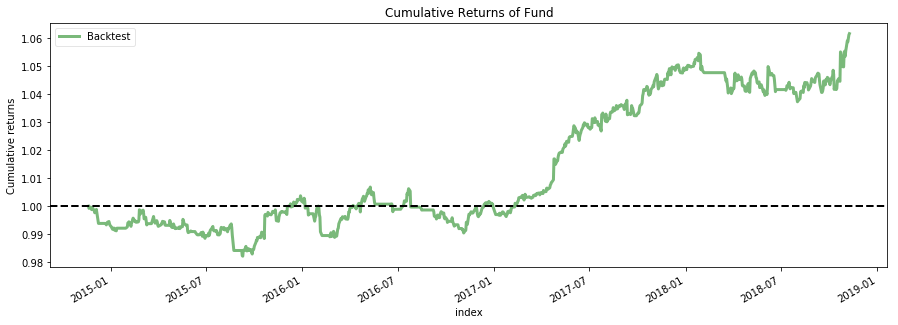

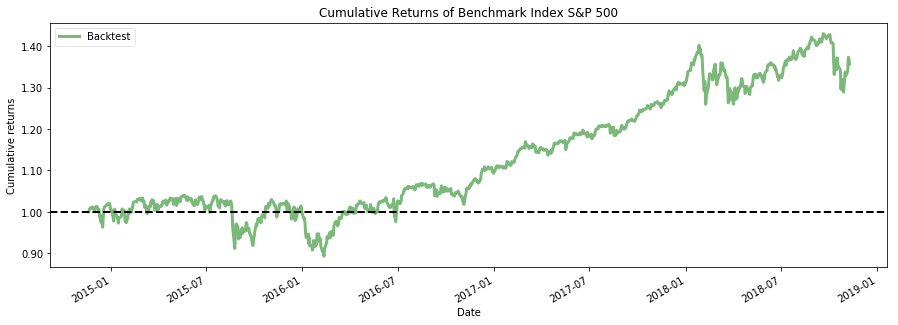

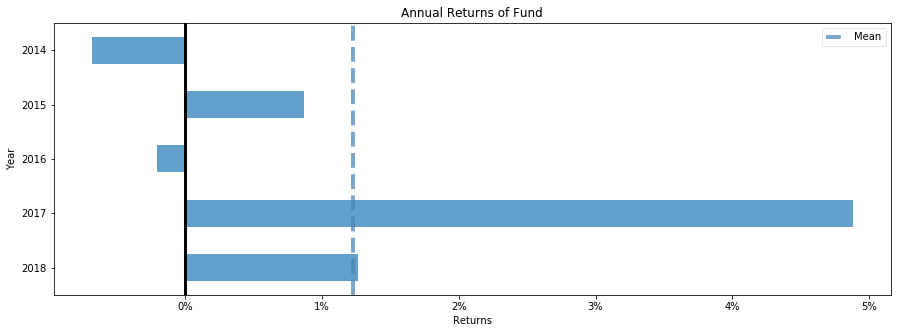

In [36]:
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
snp_ret = snp['Adj Close'].pct_change()

plt.figure(figsize = (15, 5))
pf.plot_rolling_returns(returns)
plt.title('Cumulative Returns of Fund')
plt.show()

plt.figure(figsize = (15, 5))
pf.plot_rolling_returns(snp_ret)
plt.title('Cumulative Returns of Benchmark Index S&P 500')
plt.show()

plt.figure(figsize = (15, 5))
pf.plot_annual_returns(returns)
plt.title('Annual Returns of Fund')
plt.show()

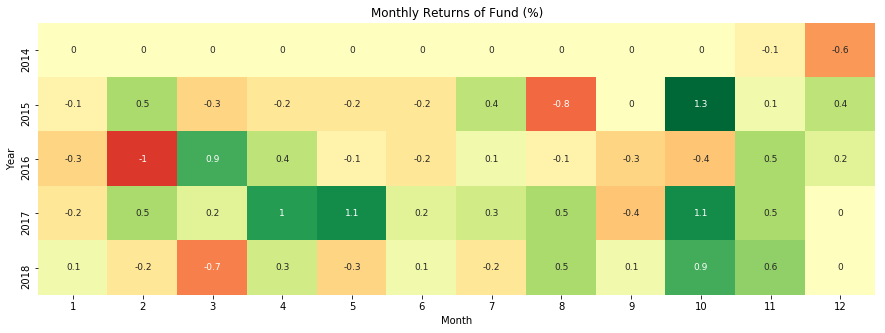

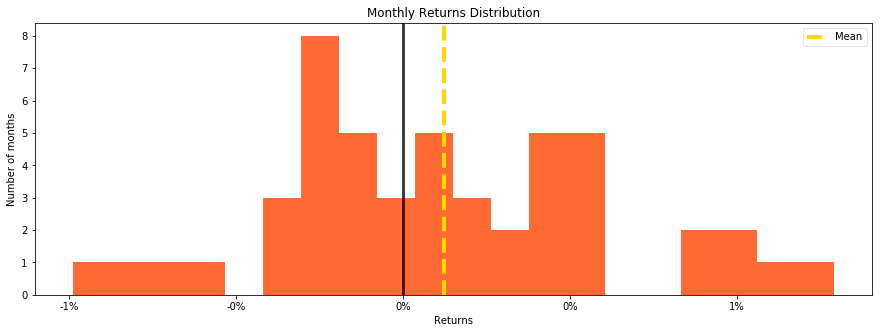

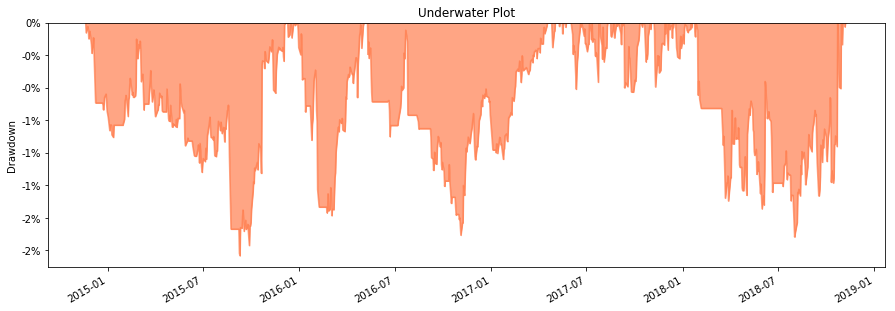

In [50]:
plt.figure(figsize = (15, 5))
pf.plot_monthly_returns_heatmap(returns)
plt.title('Monthly Returns of Fund (%)')
plt.show()

plt.figure(figsize = (15, 5))
pf.plot_monthly_returns_dist(returns)
plt.title('Monthly Returns Distribution')
plt.show()

plt.figure(figsize = (15, 5))
pf.plot_drawdown_underwater(returns)
plt.title('Underwater Plot')
plt.show()

[Top](#Table)